In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from random import sample

In [2]:
%%time
df = pd.read_csv('dataFeaturesReduced_8dec.csv',keep_default_na=False)

CPU times: user 2.97 s, sys: 370 ms, total: 3.34 s
Wall time: 4.36 s


In [3]:
df.columns

Index(['Value', 'number_with_intermediary_Beneficiary_3D',
       'max_value_Originator_Beneficiary', 'avg_value_Originator_Beneficiary',
       'avg_value_Intermediary_Beneficiary',
       'latency_Intermediary_Beneficiary',
       'frequency_with_currency_Intermediary_Beneficiary',
       'sum_value_Intermediary_Beneficiary_3D',
       'max_value_Intermediary_Beneficiary_3D',
       'frequency_with_currency_Intermediary_Beneficiary_3D', 'Flag'],
      dtype='object')

# Features Selection

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier, Pool
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

In [5]:
X = df.select_dtypes(include=np.number)
y = df['Flag']
qtr = QuantileTransformer()
scaler = MinMaxScaler()
sdt = StandardScaler()
# X = scaler.fit_transform(X)
# X = sdt.fit_transform(X)
X = qtr.fit_transform(X)

X = pd.DataFrame(X,columns=df.columns[:-1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training

In [6]:
%%time

model = CatBoostClassifier(verbose=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = [True if y =='True' else False for y in y_pred]

report = classification_report(y_test,y_pred,output_dict=True )
CM = confusion_matrix(y_test, y_pred)


TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
print('les fraudes : ')
print('bien trouvée TP : ',TP)
print('pas trouvée FN : ',FN) 
print('les normaux')
print('bien trouvée TN : ',TN)
print('pas trouvée FP : ',FP)
report

les fraudes : 
bien trouvée TP :  1658
pas trouvée FN :  987
les normaux
bien trouvée TN :  732580
pas trouvée FP :  134
CPU times: user 20min 41s, sys: 12.4 s, total: 20min 54s
Wall time: 2min 57s


{'False': {'precision': 0.998654519628064,
  'recall': 0.9998171182753435,
  'f1-score': 0.9992354807843791,
  'support': 732714},
 'True': {'precision': 0.9252232142857143,
  'recall': 0.6268431001890359,
  'f1-score': 0.747351814288934,
  'support': 2645},
 'accuracy': 0.9984755745153048,
 'macro avg': {'precision': 0.9619388669568891,
  'recall': 0.8133301092321896,
  'f1-score': 0.8732936475366566,
  'support': 735359},
 'weighted avg': {'precision': 0.9983903958427691,
  'recall': 0.9984755745153048,
  'f1-score': 0.998329484804347,
  'support': 735359}}

# Find the Frauds

In [7]:
# df = df[variable_explicative+'Flag']

In [8]:
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [9]:
idx_fraud = np.where(y==1)
X_fraud = X.loc[idx_fraud]

In [10]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_fraud)
    distortions.append(kmeanModel.inertia_)

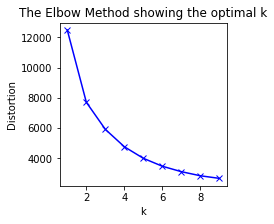

In [11]:
plt.figure(figsize=(3,3))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [12]:
nb_cluster = 3
km =  KMeans(n_clusters=nb_cluster, random_state=0)
km.fit(X_fraud)
clusters_fraud = km.predict(X_fraud)

In [13]:
pca = decomposition.PCA(n_components=2)
X_fraud_PCA = pca.fit_transform(X_fraud)

km_pca =  KMeans(n_clusters=nb_cluster, random_state=0)
km_pca.fit_transform(X_fraud_PCA)
clusters_fraud_pca = km_pca.predict(X_fraud_PCA)

In [14]:
idx_legit = np.where(y==0)
X_legit = X.loc[idx_legit]
X_PCA = pca.transform(X_legit)
x_pca = X_PCA[:,0]
y_pca = X_PCA[:,1]


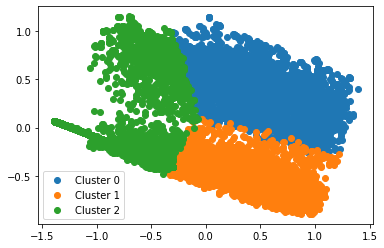

In [15]:
for i in range(nb_cluster):
    idx = np.where(clusters_fraud==i)
    X_fraud_PCA[idx]
    x_plt=X_fraud_PCA[idx][:,0]
    y_plt=X_fraud_PCA[idx][:,1]
    plt.scatter(x_plt,y_plt,label="Cluster {}".format(i))


    
plt.legend(["Cluster 0", "Cluster 1",'Cluster 2','Cluster 3'])

# plt.xlim([-0.1, 1.1])
# plt.ylim([-0.1, 1.1])

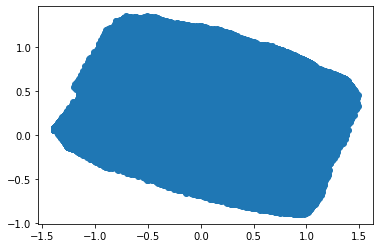

In [16]:
plt.scatter(x_pca,y_pca)

In [17]:
# plt.scatter(x_pca,y_pca)
# for i in range(nb_cluster):
#     idx = np.where(clusters_fraud==i)
#     X_fraud_PCA[idx]
#     x_plt=X_fraud_PCA[idx][:,0]
#     y_plt=X_fraud_PCA[idx][:,1]
#     print(len(x))
#     plt.scatter(x_plt,y_plt,label="Cluster {}".format(i))


    
# plt.legend(["legit","0" , "1",'2','3'])

# # plt.xlim([-0.1, 1.1])
# # plt.ylim([-0.1, 1.1])

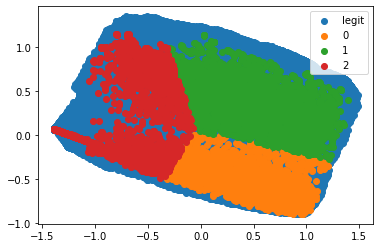

In [18]:
plt.scatter(x_pca,y_pca)
for i in range(nb_cluster):
    idx = np.where(clusters_fraud_pca==i)
    X_fraud_PCA[idx]
    x_plt=X_fraud_PCA[idx][:,0]
    y_plt=X_fraud_PCA[idx][:,1]
    plt.scatter(x_plt,y_plt)
plt.legend(["legit","0" , "1",'2','3'],loc="upper right")
plt.savefig('clusters.png')
# plt.xlim([-0.1, 1.1])
# plt.ylim([-0.1, 1.1])

# Study Predictions for each clusters

In [19]:
%%time
import shap
explainer = shap.TreeExplainer(model)

CPU times: user 1.51 s, sys: 326 ms, total: 1.83 s
Wall time: 8.61 s


In [20]:
shap_values = explainer(X_fraud)

In [21]:
shap_values_list = []

In [22]:
for i in range(nb_cluster):
    print("------------------ Cluster {} --------------------".format(i))
    index_cluster = np.where(clusters_fraud==i)
    shap_values_list.append(shap_values[index_cluster])

------------------ Cluster 0 --------------------
------------------ Cluster 1 --------------------
------------------ Cluster 2 --------------------


------------------ Cluster 0 --------------------


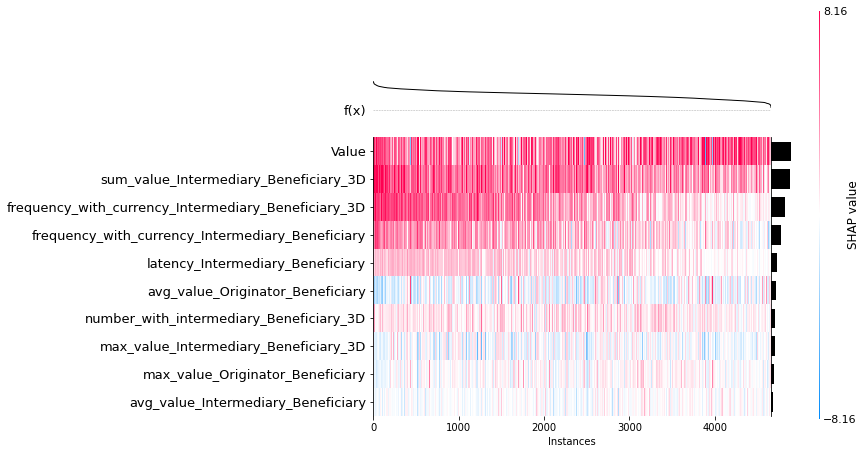

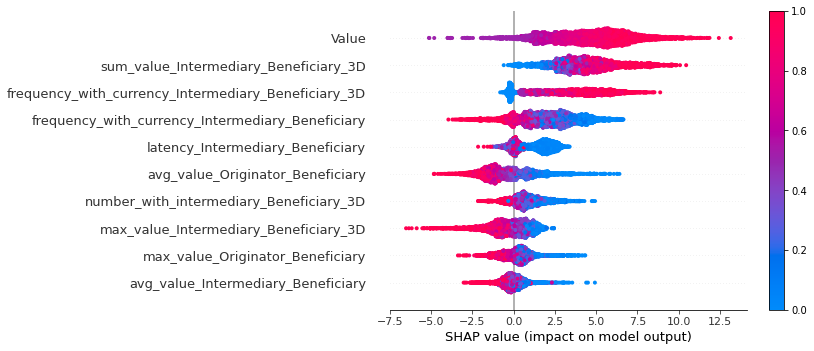

------------------ Cluster 1 --------------------


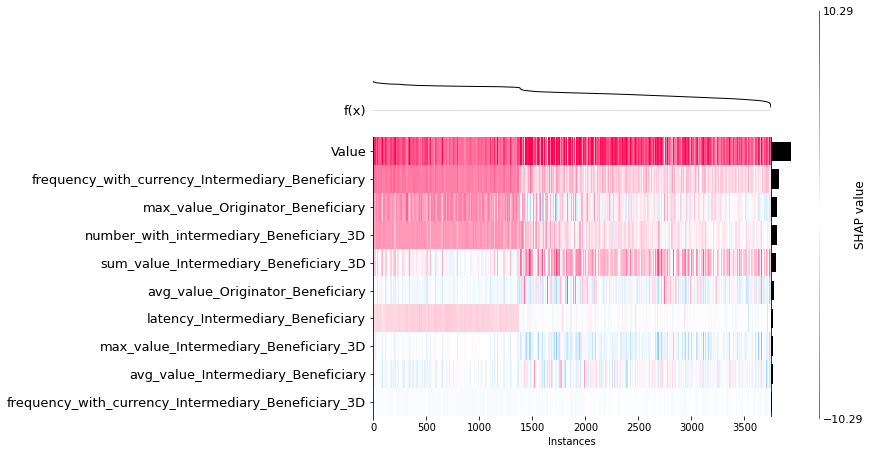

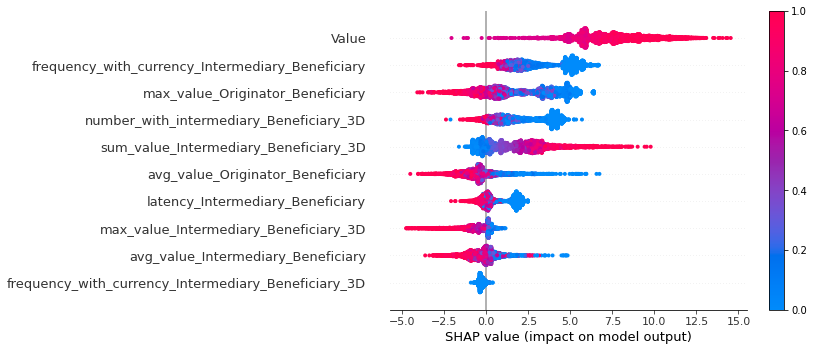

------------------ Cluster 2 --------------------


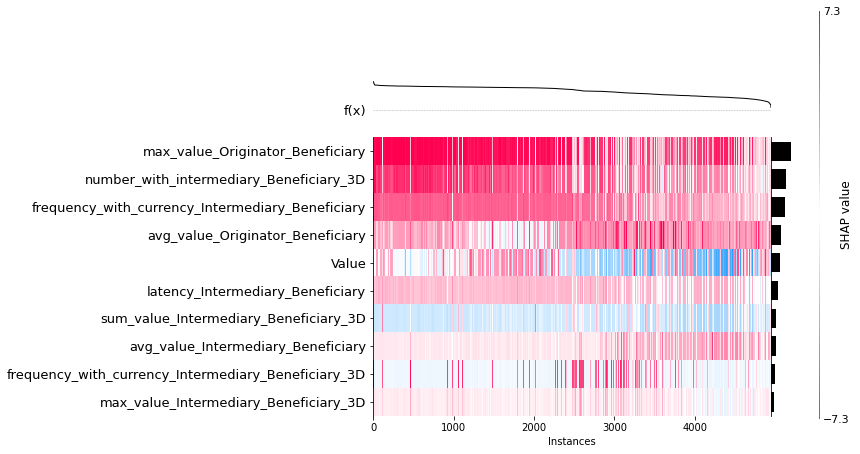

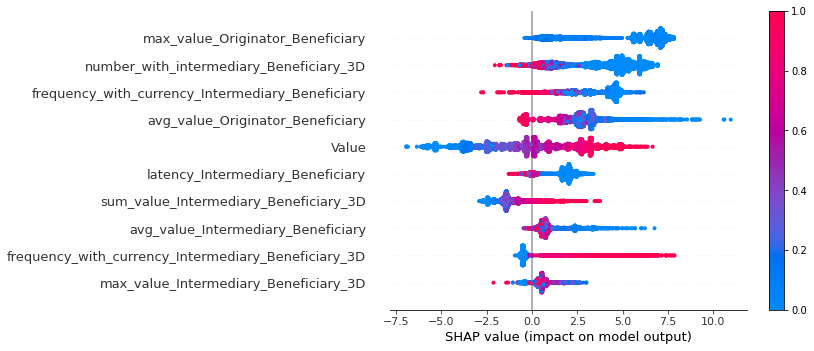

CPU times: user 3.22 s, sys: 874 ms, total: 4.1 s
Wall time: 2.13 s


In [23]:
%%time
for i in range(nb_cluster):
    print("------------------ Cluster {} --------------------".format(i))
    plt.clf()
    shap_values_tmp = shap_values_list[i]
    # shap.plots.beeswarm(shap_values_tmp)    
    shap.plots.heatmap(shap_values_tmp,instance_order = shap_values_tmp.sum(1))
    plt.tight_layout()
    plt.clf()
    shap.plots.beeswarm(shap_values_tmp, max_display=12, show=False, color_bar=False)
    plt.colorbar()
    plt.clim(0,1)
    plt.show()


In [24]:
# %%time
# for i in range(nb_cluster):
#     print("------------------ Cluster {} --------------------".format(i))
#     plt.clf()
#     shap_values_tmp = shap_values_list[i]
#     # shap.plots.beeswarm(shap_values_tmp)    
#     shap.plots.heatmap(shap_values_tmp,instance_order = shap_values_tmp.sum(1),show=False)
#     plt.tight_layout()
#     plt.savefig('clusters_{}_HM.png'.format(i))
#     # plt.savefig('clusters_{}_HM.png'.format(i))
#     plt.clf()
#     shap.plots.beeswarm(shap_values_tmp, max_display=12, show=False, color_bar=False)
#     # plt.savefig('clusters.png')
#     plt.colorbar()
#     plt.clim(0,1)
#     # plt.tight_layout()
#     # plt.figure(figsize=(450, 300))
#     plt.savefig('clusters_{}_BM.png'.format(i),bbox_inches='tight')

------------------ Cluster 0 --------------------
----- over 17.797524114462426 


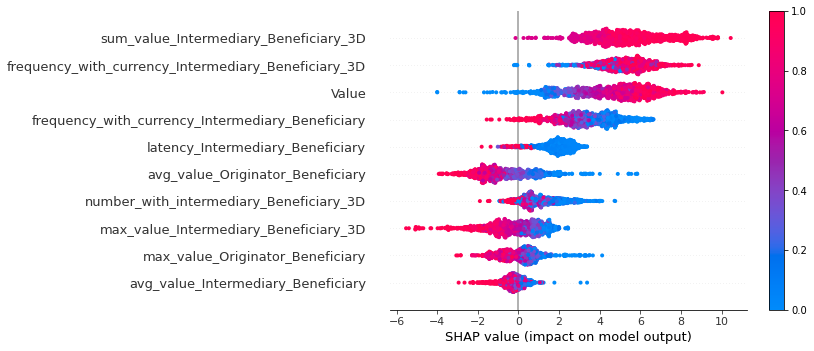

------------------ Cluster 1 --------------------
----- over 20.117393004086516 


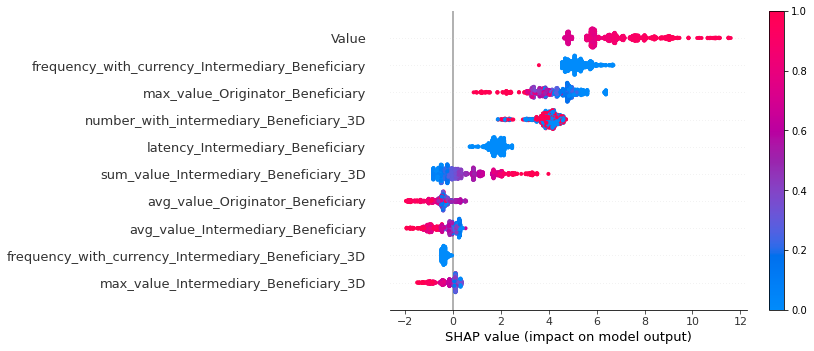

------------------ Cluster 2 --------------------
----- over 20.74978517856646 


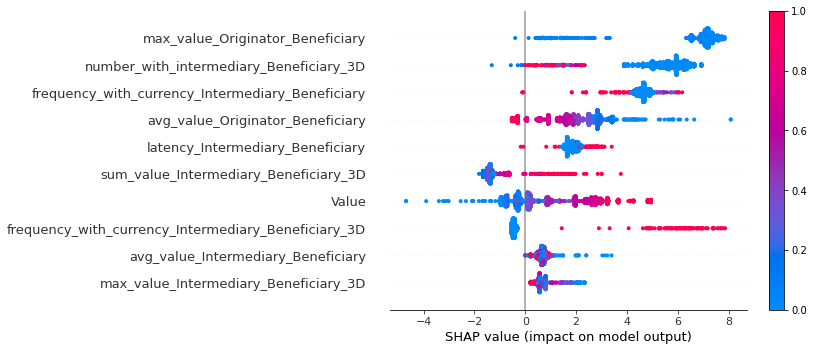

CPU times: user 1.81 s, sys: 514 ms, total: 2.32 s
Wall time: 1.21 s


In [25]:
%%time
for i in range(nb_cluster):
    print("------------------ Cluster {} --------------------".format(i))
    shap_values_tmp = shap_values_list[i]
    sum_values = np.array([shap_values_tmp.values[j].sum() for j in range(len(shap_values_tmp.values))])
    q1 = np.percentile(sum_values,5)
    q3 = np.percentile(sum_values,70)
    
    
    idx_q1 = np.where(sum_values<q1)
    idx_q3 = np.where(sum_values>q3)
    
#     print('----- under {} '.format(q1))
    
#     shap.plots.beeswarm(shap_values[idx_q1])    
#     shap.plots.heatmap(shap_values[idx_q1],instance_order = shap_values[idx_q1].sum(1))
    
    print('----- over {} '.format(q3))
    # shap.plots.beeswarm(shap_values_tmp[idx_q3])
    shap.plots.beeswarm(shap_values_tmp[idx_q3], show=False, color_bar=False)
    plt.colorbar()
    plt.clim(0,1)
    plt.show()
    #shap.summary_plot(shap_values_tmp[idx_q3])
#     shap.plots.heatmap(shap_values_tmp[idx_q3],instance_order = shap_values_tmp[idx_q3].sum(1), feature_values=shap_values_tmp[idx_q3].abs.max(0))

# Interpretation variable de base 

In [26]:
# len(clusters_fraud)

In [27]:

X_fraud['Cluster'] = clusters_fraud
# base_cols = ['Originator','Intermediary','Beneficiary','Currency','Value','Fulldate','OriginatorCountry','IntermediaryCountry','BeneficiaryCountry']

In [28]:
X_fraud['Value'].max()

1.0

In [29]:
# df_fraud.loc[:,base_cols] = df.loc[:,base_cols]

In [30]:
for cluster in range(nb_cluster):
    print("------------------ Cluster {} --------------------".format(cluster))
    df_cluster = X_fraud[X_fraud['Cluster']==cluster]
    print("Nombre de transactions : {}".format(len(df_cluster)))
    print("Moyenne montants : {}".format(round(df_cluster['Value'].mean(),2)))

------------------ Cluster 0 --------------------
Nombre de transactions : 4662
Moyenne montants : 0.81
------------------ Cluster 1 --------------------
Nombre de transactions : 3752
Moyenne montants : 0.89
------------------ Cluster 2 --------------------
Nombre de transactions : 4953
Moyenne montants : 0.39


In [31]:
df.iloc[X_fraud[X_fraud['Cluster']==0].index]

,Value,number_with_intermediary_Beneficiary_3D,max_value_Originator_Beneficiary,avg_value_Originator_Beneficiary,avg_value_Intermediary_Beneficiary,latency_Intermediary_Beneficiary,frequency_with_currency_Intermediary_Beneficiary,sum_value_Intermediary_Beneficiary_3D,max_value_Intermediary_Beneficiary_3D,frequency_with_currency_Intermediary_Beneficiary_3D,Flag
2681,1140732,90,2381350,536835.349754,548890.281690,0.0,69,1373633,1140732,2,True
4142,345740,91,1088175,208334.551948,270133.000000,0.0,20,825254,345740,3,True
4184,230931,91,1088175,208334.551948,270133.000000,120.0,20,825254,345740,3,True
4282,1306478,463,3981596,501797.469008,341364.991416,0.0,97,2202202,1306478,3,True
4311,689899,838,2412817,212051.754135,219334.062753,0.0,205,4099683,689899,6,True
...,...,...,...,...,...,...,...,...,...,...,...
3670707,955626,98,3009242,418984.028986,482155.348837,240.0,8,4592020,1015459,5,True
3670887,95589,2385,256905,64165.100000,100805.780744,1260.0,135,955311,212425,4,True
3671943,1015459,98,3009242,418984.028986,482155.348837,2700.0,8,4592020,1015459,5,True
3674914,285030,856,450795,60352.486804,58203.427165,60.0,104,457484,285030,2,True


In [32]:
for cluster in range(nb_cluster):
    print("------------------ Cluster {} --------------------".format(cluster))
    df_cluster = df.iloc[X_fraud[X_fraud['Cluster']==cluster].index]
    print("Nombre de transactions : {}".format(len(df_cluster)))
    print("Moyenne montants : {}".format(round(df_cluster['Value'].mean(),2)))

------------------ Cluster 0 --------------------
Nombre de transactions : 4662
Moyenne montants : 772621.93
------------------ Cluster 1 --------------------
Nombre de transactions : 3752
Moyenne montants : 1273978.44
------------------ Cluster 2 --------------------
Nombre de transactions : 4953
Moyenne montants : 107564.96


In [33]:
# for cluster in range(nb_cluster):
#     print("------------------ Cluster {} --------------------".format(cluster))
#     df_cluster = df_fraud[df_fraud['Cluster']==cluster][base_cols]
#     nb_int = len(df_cluster[df_cluster['Intermediary']==df_cluster['Beneficiary']])
#     print("Nombre de transactions : {}".format(len(df_cluster)))
#     print("Moyenne montants : {}".format(round(df_cluster['Value'].mean(),2)))
#     print("Proportion de transactions avec intermédiaire : {}%".format(round(nb_int/len(df_cluster),2)))
#     nb_dinstict_currency = len(df_cluster['Currency'].unique())
#     nb_distinct_originator = len(df_cluster['Originator'].unique())
#     nb_dinstict_intermediary = len(df_cluster['Intermediary'].unique())
#     nb_dinstict_beneficiary = len(df_cluster['Beneficiary'].unique())
#     nb_distinct_originator_country = len(df_cluster['OriginatorCountry'].unique())
#     nb_dinstict_intermediary_country = len(df_cluster['IntermediaryCountry'].unique())
#     nb_dinstict_beneficiary_country = len(df_cluster['BeneficiaryCountry'].unique())
#     print("Nombre de devises distinctes : {}".format(nb_dinstict_currency))
#     print("Nombre de Originator distinctes : {}".format(nb_distinct_originator))
#     print("Nombre de Intermediary distinctes : {}".format(nb_dinstict_intermediary))
#     print("Nombre de Beneficiary distinctes : {}".format(nb_dinstict_beneficiary))
#     print("Nombre de Originator Country distinctes : {}".format(nb_distinct_originator_country))
#     print("Nombre de Intermediary Country distinctes : {}".format(nb_dinstict_intermediary_country))
#     print("Nombre de Beneficiary Country distinctes : {}".format(nb_dinstict_beneficiary_country))

In [34]:
# import plotly.express as px

# for cluster in range(nb_cluster):
#     print("------------------ Cluster {} --------------------".format(cluster))
#     df_cluster = df_fraud[df_fraud['Cluster']==cluster][base_c
#     fig = px.line(df_cluster, x='Fulldate', y="Value")
#     fig.show()

# Multi Classification

In [35]:
y_multi = 1*y

In [36]:
y_multi.iloc[np.where(y_multi==1)] = clusters_fraud+1

In [37]:
y_train_multi = y_multi.iloc[y_train.index]
y_test_multi = y_multi.iloc[y_test.index]

In [38]:
%%time

model = CatBoostClassifier(verbose=0)

model.fit(X_train, y_train_multi)



CPU times: user 42min 4s, sys: 11.6 s, total: 42min 15s
Wall time: 6min 10s


In [73]:
def detect_fraud(y_preds_proba,threshold):
    y_pred = []
    y_pred_check = []
    for j in range(len(y_preds_proba)):
        f = y_preds_proba[j][1:].sum()
        if f > threshold:
            y_pred.append(np.argmax(y_preds_proba[j][1:])+1)
            y_pred_check.append(1)
        else :
            y_pred.append(0)
            y_pred_check.append(0)
    return [y_pred,y_pred_check]

In [155]:
%%time
y_preds_proba = model.predict_proba(X_test)
y_preds = model.predict(X_test)[:,0]

y_pred, y_pred_check = detect_fraud(y_preds_proba,0.5)

# base = mounting_cost(X_test_multi,y_preds,y_test_multi,ca,cc)
# print(costs)
report = classification_report(y_test_multi,y_pred,output_dict=True )
report

CPU times: user 11.2 s, sys: 71 ms, total: 11.2 s
Wall time: 3.49 s


{'0': {'precision': 0.9984395081111507,
  'recall': 0.999841684477163,
  'f1-score': 0.9991401043467351,
  'support': 732714},
 '1': {'precision': 0.9139784946236559,
  'recall': 0.551948051948052,
  'f1-score': 0.6882591093117408,
  'support': 924},
 '2': {'precision': 0.9523809523809523,
  'recall': 0.42160737812911725,
  'f1-score': 0.5844748858447489,
  'support': 759},
 '3': {'precision': 0.9210526315789473,
  'recall': 0.6912681912681913,
  'f1-score': 0.7897862232779098,
  'support': 962},
 'accuracy': 0.9982783919146975,
 'macro avg': {'precision': 0.9464628966736766,
  'recall': 0.6661663264556308,
  'f1-score': 0.7654150806952836,
  'support': 735359},
 'weighted avg': {'precision': 0.9981846032340965,
  'recall': 0.9982783919146975,
  'f1-score': 0.9980475993609477,
  'support': 735359}}

In [156]:
report = classification_report(y_test,y_pred_check,output_dict=True )
report

{'False': {'precision': 0.9984395081111507,
  'recall': 0.999841684477163,
  'f1-score': 0.9991401043467351,
  'support': 732714},
 'True': {'precision': 0.9282178217821783,
  'recall': 0.5671077504725898,
  'f1-score': 0.7040600797934757,
  'support': 2645},
 'accuracy': 0.9982851913147184,
 'macro avg': {'precision': 0.9633286649466645,
  'recall': 0.7834747174748764,
  'f1-score': 0.8516000920701055,
  'support': 735359},
 'weighted avg': {'precision': 0.9981869289486734,
  'recall': 0.9982851913147184,
  'f1-score': 0.9980787361375429,
  'support': 735359}}

# Minimize mounting costs

In [143]:
def mounting_cost(values,y_pred,y_true,ca,cc):
    costs = 0
    y_pred = list(y_pred)
    y_true = list(y_true)
    for i in range(len(y_true)):
        pred = y_pred[i]
        true = y_true[i]
        if pred >= 1:
            if true == 1:
                costs = costs + ca
            else:
                costs = costs +ca + cc
        elif (pred ==0) and (true==1):
            amt = values.iloc[i]
            costs = costs + amt
    return costs

In [185]:
round(0.869,3)

0.869

In [193]:
ida=[1,2]
a = np.array([6,2,3,9])
b = np.argmin(a[ida])
ida[b]

1

In [ ]:
y_preds_proba = model.predict_proba(X_test)
y_preds = model.predict(X_test)[:,0]

y_pred, y_pred_check = detect_fraud(y_preds_proba,0.5)

In [225]:
import math
def minimize_mounting_cost(values,y_preds_proba,ca,cc):
    
    list_f1 = []
    list_costs = []
    idxs = np.arange(0,1,0.01)
    for i in idxs:
        y_pred, y_pred_check = detect_fraud(y_preds_proba,i)
        costs = mounting_cost(values,y_pred_check,y_test,ca,cc)
        f1 = classification_report(y_test,y_pred_check,output_dict=True )['macro avg']['f1-score']
        list_costs.append(costs)
        list_f1.append(f1)
                
    maxF1 = np.max(np.array(list_f1))
    maxF1 = math.floor(maxF1 * 100)/100.0
    idx_maxF1 = np.where(np.array(list_f1)>=maxF1)[0]
    reduced_costs = np.array(list_costs)[idx_maxF1]
    reduced_costs = np.argmin(reduced_costs)
    threshold = idx_maxF1[reduced_costs]
    threshold = idxs[threshold]
    
    print(threshold)

    return [list_costs,list_f1,threshold]

In [ ]:
ca = 100
cc = 50

In [226]:
list_costs,list_f1,threshold = minimize_mounting_cost(values,y_preds_proba,ca,cc)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


0.19


In [228]:
y_pred, y_pred_check = detect_fraud(y_preds_proba,threshold)
costs = mounting_cost(values,y_pred_check,y_test,ca,cc)
f1 = classification_report(y_test,y_pred_check,output_dict=True )['macro avg']['f1-score']
print(costs)
print(f1)

975478588
0.8513882422713249


([<matplotlib.axis.XTick at 0x7f4e89029430>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

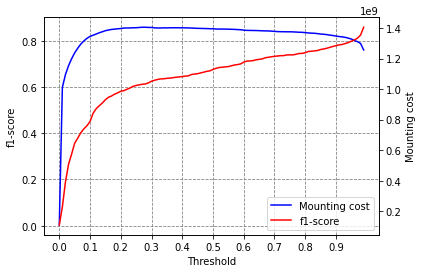

In [262]:
fig, ax1 = plt.subplots()
ax2= ax1.twinx()

idx = np.arange(0,1,0.01)

ax1.plot(idx,list_f1,color='blue', label='Mounting cost')

ax2.plot(idx,list_costs,color = 'red', label='f1-score')

ax1.grid( ls='--', color='grey', axis='both')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=0)

ax1.set_xlabel('Threshold')
ax1.set_ylabel('f1-score')
ax2.set_ylabel('Mounting cost')
plt.xticks(np.arange(0, 1, 0.1))
# plt.grid(True)